In [0]:
import pandas as pd

In [0]:
storage_account_name = "mehdistokage" 
container_name = "briefesther" 
storage_account_key = "STORAGE_ACCOUNT_KEY"  

mount_point = "/mnt/briefesther"

try: 
    dbutils.fs.unmount(mount_point)
except:
    pass

if not any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.mount(
        source = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net",
        mount_point = mount_point,
        extra_configs = {f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_account_key}
    )

display(dbutils.fs.ls(mount_point))

path,name,size,modificationTime
dbfs:/mnt/briefesther/data_bronze/,data_bronze/,0,0
dbfs:/mnt/briefesther/data_gold/,data_gold/,0,0
dbfs:/mnt/briefesther/data_silver/,data_silver/,0,0


# Bronze

In [0]:
df_bronze_2019 = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/mnt/briefesther/data_bronze/2019.csv")

df_bronze_2020 = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/mnt/briefesther/data_bronze/2020.csv")

df_bronze_2021 = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/mnt/briefesther/data_bronze/2021.csv")

df_bronze = df_bronze_2019.union(df_bronze_2020).union(df_bronze_2021)

df_bronze.show(truncate=False)


+-------+---+----------+------------------+-----------------------------+-----------------------+---+--------+--------+
|SO43701|11 |2019-07-01|Christy Zhu       |christy12@adventure-works.com|Mountain-100 Silver, 44|16 |3399.99 |271.9992|
+-------+---+----------+------------------+-----------------------------+-----------------------+---+--------+--------+
|SO43704|1  |2019-07-01|Julio Ruiz        |julio1@adventure-works.com   |Mountain-100 Black, 48 |1  |3374.99 |269.9992|
|SO43705|1  |2019-07-01|Curtis Lu         |curtis9@adventure-works.com  |Mountain-100 Silver, 38|1  |3399.99 |271.9992|
|SO43700|1  |2019-07-01|Ruben Prasad      |ruben10@adventure-works.com  |Road-650 Black, 62     |1  |699.0982|55.9279 |
|SO43703|1  |2019-07-01|Albert Alvarez    |albert7@adventure-works.com  |Road-150 Red, 62       |1  |3578.27 |286.2616|
|SO43697|1  |2019-07-01|Cole Watson       |cole1@adventure-works.com    |Road-150 Red, 62       |1  |3578.27 |286.2616|
|SO43699|1  |2019-07-01|Sydney Wright   

# Silver

In [0]:
from pyspark.sql.functions import col

silver_path = "/mnt/briefesther/data_silver/"

df_bronze = df_bronze.toDF(*[col_name.replace(".", "_").replace(",", "_").replace(" ", "_").replace("-", "_") for col_name in df_bronze.columns])

df_silver = df_bronze.dropDuplicates().na.drop()

df_silver.write.format("parquet").mode("overwrite").save(silver_path)

df_silver = spark.read.format("parquet").load(silver_path)
df_silver.show(truncate=False)


+-------+---+----------+----------------+------------------------------+-----------------------+---+--------+--------+
|SO43701|11 |2019_07_01|Christy_Zhu     |christy12@adventure_works_com |Mountain_100_Silver__44|16 |3399_99 |271_9992|
+-------+---+----------+----------------+------------------------------+-----------------------+---+--------+--------+
|SO43790|1  |2019-07-12|Abigail Perry   |abigail75@adventure-works.com |Mountain-100 Silver, 38|1  |3399.99 |271.9992|
|SO44017|1  |2019-07-27|Jack Young      |jack54@adventure-works.com    |Road-150 Red, 62       |1  |3578.27 |286.2616|
|SO44378|1  |2019-09-11|Marshall Rai    |marshall38@adventure-works.com|Mountain-100 Black, 42 |1  |3374.99 |269.9992|
|SO44726|1  |2019-10-28|Dylan Bryant    |dylan17@adventure-works.com   |Road-650 Black, 58     |1  |699.0982|55.9279 |
|SO44855|1  |2019-11-07|Isabella Brown  |isabella61@adventure-works.com|Road-650 Red, 58       |1  |699.0982|55.9279 |
|SO44999|1  |2019-11-25|Devin Gonzalez  |devin31

# Gold

In [0]:
from pyspark.sql.functions import avg, count

gold_path = "/mnt/briefesther/data_gold/"

# ventes moyennes et total de transactions
df_gold = df_silver.groupBy("SO43701").agg(
    avg("3399_99").alias("avg_sales"),
    count("*").alias("total_transactions")
)

df_gold.write.format("parquet").mode("overwrite").save(gold_path)

df_gold = spark.read.format("parquet").load(gold_path)
df_gold.show(truncate=False)


+-------+------------------+------------------+
|SO43701|avg_sales         |total_transactions|
+-------+------------------+------------------+
|SO45078|3578.27           |1                 |
|SO43830|3578.27           |1                 |
|SO47586|782.99            |1                 |
|SO48696|2443.35           |1                 |
|SO46268|3578.27           |1                 |
|SO48837|2181.5625         |1                 |
|SO48551|782.99            |1                 |
|SO46164|3578.27           |1                 |
|SO47299|2443.35           |1                 |
|SO56348|12.96             |3                 |
|SO58552|62.66             |3                 |
|SO62915|31.3675           |4                 |
|SO60172|187.92333333333332|3                 |
|SO59804|1158.485          |2                 |
|SO50568|782.99            |1                 |
|SO54042|20.774285714285714|7                 |
|SO56522|596.6566666666666 |3                 |
|SO58211|19.823333333333334|3           

# Partie 4

+-------+------------------+------------------+
|SO43701|avg_sales         |total_transactions|
+-------+------------------+------------------+
|SO45078|3578.27           |1                 |
|SO43830|3578.27           |1                 |
|SO47586|782.99            |1                 |
|SO48696|2443.35           |1                 |
|SO46268|3578.27           |1                 |
|SO48837|2181.5625         |1                 |
|SO48551|782.99            |1                 |
|SO46164|3578.27           |1                 |
|SO47299|2443.35           |1                 |
|SO56348|12.96             |3                 |
|SO58552|62.66             |3                 |
|SO62915|31.3675           |4                 |
|SO60172|187.92333333333332|3                 |
|SO59804|1158.485          |2                 |
|SO50568|782.99            |1                 |
|SO54042|20.774285714285714|7                 |
|SO56522|596.6566666666666 |3                 |
|SO58211|19.823333333333334|3           

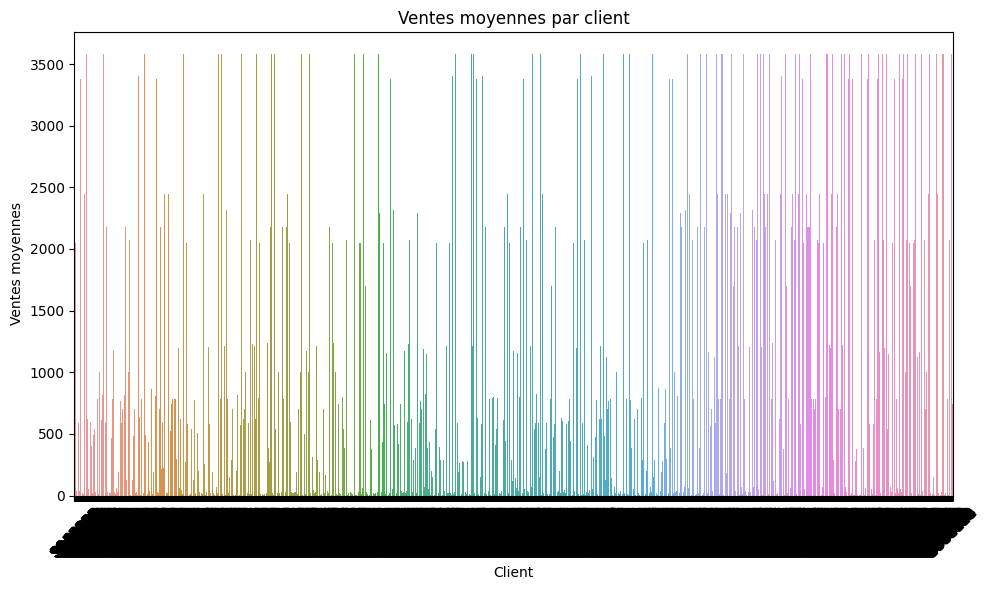

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

gold_path = "/mnt/briefesther/data_gold/"
df_gold = spark.read.format("parquet").load(gold_path)

df_gold.show(truncate=False)

pd_gold = df_gold.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=pd_gold, x="SO43701", y="avg_sales")
plt.title("Ventes moyennes par client")
plt.xlabel("Client")
plt.ylabel("Ventes moyennes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Partie 5

In [0]:
bronze_path = "/mnt/briefesther/data_bronze/"
silver_path = "/mnt/briefesther/data_silver/"
gold_path = "/mnt/briefesther/data_gold/"

df_bronze.coalesce(1).write.mode("overwrite").parquet(bronze_path)
df_silver.coalesce(1).write.mode("overwrite").parquet(silver_path)
df_gold.coalesce(1).write.mode("overwrite").parquet(gold_path)

Les fichiers Silver ont été sauvegardés avec succès en format Parquet.
